# Import modules, libraries, and packages

In [85]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Get the current working directory of the notebook
CURRENT_DIR = os.getcwd()
# Add the parent directory of the notebook to the Python path
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, '..', '..', '..'))
sys.path.append(ROOT_DIR)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import geopandas as gpd
from fiona.crs import from_epsg

import warnings


from utils.utils import load_util_data, get_unusable_basins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and constants

In [86]:
data_dir, data_gen = load_util_data(CURRENT_DIR)

BASINS_DIR = data_dir['data_dir_camels_spat_nh']
DATASET = data_dir['data_dir_camels_spat_nh'].split('/')[-1]
INPUT_FILES_DIR = data_dir['data_dir_camels_spat_nh']
BASIN_SET_FILES_DIR = os.path.join(INPUT_FILES_DIR, 'merged_lumped_shapes')

COUNTRIES = ['USA']   #data_gen['countries']

## Load unusable basins

In [87]:
unusuable_basins = get_unusable_basins(INPUT_FILES_DIR, data_gen['camels_spat_unusable'])

## Loading basin IDs

In [88]:
##Read the basin shapefile
gdf_basins = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'merged_lumped_outlines.shp'))
# Subset the basins to only include the ones that are usable
gdf_basins = gdf_basins[~gdf_basins['Station_id'].isin(unusuable_basins) & gdf_basins['Country'].isin(COUNTRIES)]

# Set the CRS for gdf_basins
gdf_basins.crs = from_epsg(4269)

# Set a common CRS for both GeoDataFrames
common_crs = 'EPSG:4269'
gdf_basins = gdf_basins.to_crs(common_crs)


states = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'usa-states-census-2014.shp'))
# Set the CRS for the GeoDataFrame
states.crs = common_crs
# Perform the transformation
states = states.to_crs(common_crs)

## Load 'bad' basins

In [89]:
# bad_basin_file = os.path.join('data', '000_basin_file.txt')
# # Read the file and store the basin IDs in a list
# with open(bad_basin_file, 'r') as f:
#     bad_basins = f.read().splitlines()
    
# # Filter the GeoDataFrame to only include bad basins
# bad_basins_gdf = gdf_basins[gdf_basins['Station_id'].isin(bad_basins)]

In [90]:
bad_basin_file = os.path.join('data', 'worst20_basins_top_50.csv')
# Load the CSV file
bad_basins_df = pd.read_csv(bad_basin_file)

# Convert column 'basin' to string of 8 characters with leading zeros
bad_basins_df['basin'] = bad_basins_df['basin'].astype(str).str.zfill(8)

bad_basins_gdf = gdf_basins[gdf_basins['Station_id'].isin(bad_basins_df['basin'])]

# Catchments plots

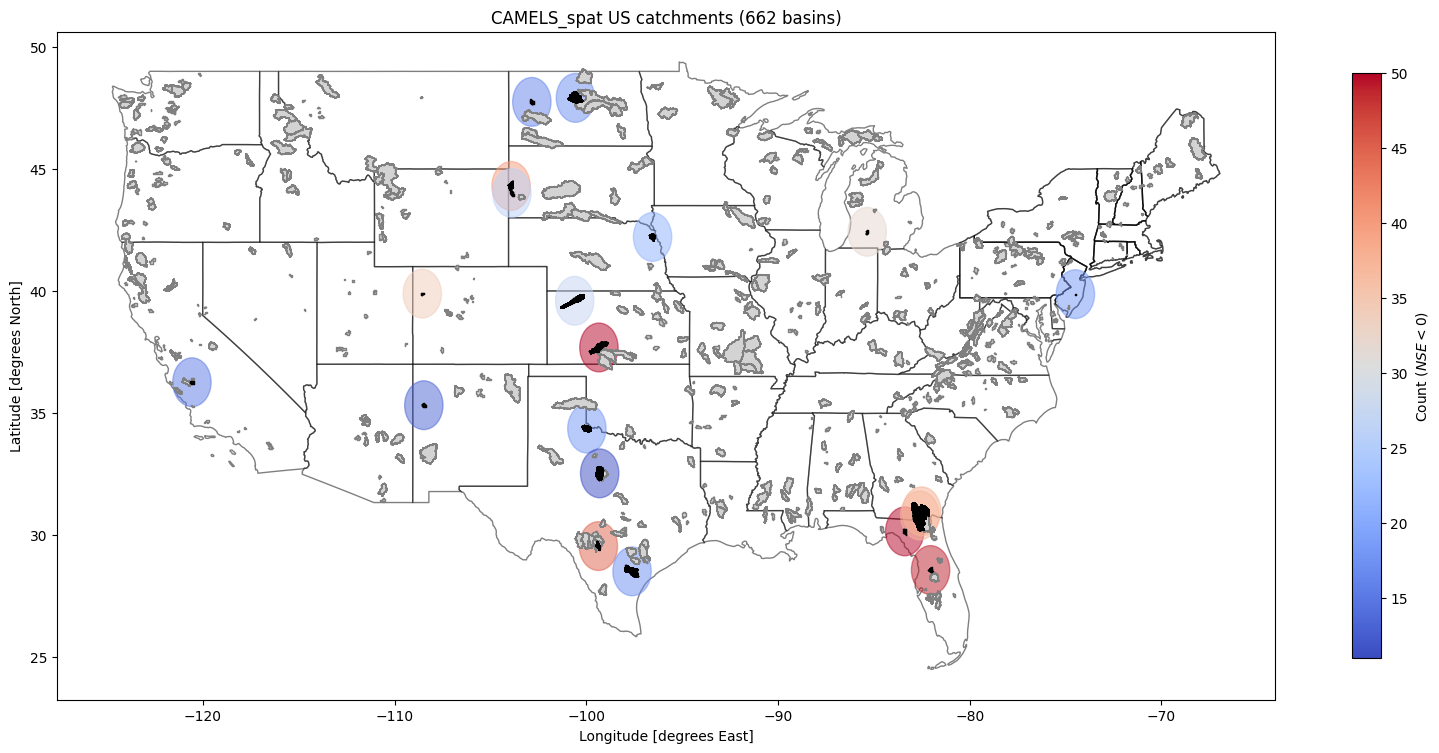

In [91]:
# Load the states GeoDataFrame
states = gpd.read_file(os.path.join(BASIN_SET_FILES_DIR, 'usa-states-census-2014.shp'))

# Assuming common_crs is the desired CRS for the analysis, you need to set the CRS for gdf_basins
# Replace 'common_crs' with the appropriate CRS for your data
gdf_basins = gdf_basins.to_crs(common_crs)

# Suppress the warning
warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 12))

# Plot state boundaries
states.boundary.plot(ax=ax, color=None, edgecolor='k', linewidth=1, alpha=0.5, zorder=1)

# Plot all basins in light gray
gdf_basins.plot(ax=ax, color='lightgray', edgecolor='gray', linewidth=1, zorder=2)

# Highlight bad basins (assuming bad_basins is a list of basin IDs)
bad_basins_gdf.plot(ax=ax, color='black', edgecolor='black', linewidth=1, zorder=3)

# Normalize the counts for colormap
norm = Normalize(vmin=bad_basins_df['count'].min(), vmax=bad_basins_df['count'].max())
# Create a scalar mappable to map counts to colors
scalar_mappable = ScalarMappable(norm=norm, cmap='coolwarm')

# Iterate over bad basins and plot circles with colormap
for _, basin in bad_basins_df.iterrows():
    basin_geometry = gdf_basins[gdf_basins['Station_id'] == basin['basin']].geometry
    centroid = basin_geometry.to_crs(common_crs).centroid.values[0]  # Project to common CRS before computing centroid
    
    count_color = scalar_mappable.to_rgba(basin['count'])
    ax.add_patch(plt.Circle((centroid.x, centroid.y), 1.0, color=count_color, alpha=0.5))

# Add colorbar
cbar = plt.colorbar(scalar_mappable, ax=ax, shrink=0.5)  # Adjust the shrink value to change the height of the colorbar
cbar.set_label('Count ($NSE<0$)')

ax.set_title(f"CAMELS_spat US catchments ({len(gdf_basins)} basins)")
ax.set_xlabel('Longitude [degrees East]')
ax.set_ylabel('Latitude [degrees North]')

# Layout
plt.tight_layout()

# Show the plot
plt.show()